In [54]:
%matplotlib inline
from matplotlib.mlab import prctile_rank
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import sys
sys.path.append('..')
from pickle_fns import *
import numpy as np

# Get the close logs for the line
from scipy import spatial
from numpy import ones,vstack
from numpy.linalg import lstsq

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib.colors as colors

# npzfile=np.load('xyzlogs.npy.npz')

# ulablesfile='tikamgarh_thck_labels.npy'
# np.savez(layers_outfile, unique_lbls,lith_dict,xi,yi,layers)
# np.save(ulablesfile, unique_lbls)



In [191]:

def gety(x,points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
#     print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return m*x+c
def get_indx_of_croockedline(coords,crooked_line):
    myKDTree = spatial.KDTree(coords)
    final_x=[]
    final_y=[]
    for i in range(1,len(crooked_line)):
        point_pair=np.array([crooked_line[i],crooked_line[i-1]])
    #     print(point_pair[:,0])

    #     
        sel_xi=xi[xi>=min(point_pair[:,0]) ]
        sel_xi=sel_xi[sel_xi<=max(point_pair[:,0])]
    #     break
        final_x.extend(sel_xi)
        final_y.extend(gety(sel_xi,point_pair))


    #get close_y index
    IND=[]
    for pt in zip(final_x,final_y):
        distance,index=myKDTree.query(pt)
        IND.append(index)
    return IND
def loggify(thicks_of_loc,labels,interval):
    rock_log=[]
    depth_log=[0]
    for layer,label in zip(thicks_of_loc,labels):
        for dt in np.arange(0,layer,interval):
            rock_log.append(label)
            depth_log.append(depth_log[-1]+interval)
    return {'Depth':depth_log[:-1],'Lithology':np.array(rock_log)}
def clip_longer_logs(volumelogs):
    lengths=[len(v['Lithology'])  for v in volumelogs]
    ml=min(lengths)
    i=0
    for v in volumelogs:
        i +=1
        v['Depth']=v['Depth'][:ml]
        v['Lithology']=v['Lithology'][:ml]
    return volumelogs

# np.array(xi),sum(lengths)
def getasection(volumelogs,coords,x=78.8):
#     x=78.8
    coords=np.array(coords)
    closeid=np.argmin(abs(coords[:,0]-x),axis=0)
    sec_x=coords[closeid,0]
    # coords[:,0]-x
    x_index=np.where(coords[:,0]==sec_x)[0]
    sec_logs=[]
    for i in x_index:
    #     print(i)
        sec_logs.append(np.array(volumelogs[i]['Lithology'] ))
    return coords[x_index,0],coords[x_index,1],volumelogs[x_index[0]]['Depth'],np.array(sec_logs)
# np.array(xi),sum(lengths)
def get_crooked_section(volumelogs,coords,xys):
#     x=78.8
    coords=np.array(coords)
    closeid=np.argmin(abs(coords[:,0]-x),axis=0)
    sec_x=coords[closeid,0]
    # coords[:,0]-x
    x_index=np.where(coords[:,0]==sec_x)[0]
    sec_logs=[]
    for i in x_index:
    #     print(i)
        sec_logs.append(np.array(volumelogs[i]['Lithology'] ))
    return coords[x_index,0],coords[x_index,1],volumelogs[x_index[0]]['Depth'],np.array(sec_logs)
def design_crooked_section(loc_array,vesdf):
    loc_coords=[]
    for loc in loc_array:
        loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing']].values.astype(float))
    
    return loc_coords
def get_loc_lines(crooked_line,sec_logs):
    miny=min(crooked_line[:,1])
    maxy=max(crooked_line[:,1])
    perunit=len(sec_logs)/(maxy-miny)
    loc1x=[]
    loc1y=[]
    crooked_line
    for i in range(len(crooked_line)):
        lxval=(crooked_line[i,1]-miny)*perunit
        loc1x.append([lxval]*10)
        loc1y.append(list(range(0,400,40)))
    len(loc1x),len(loc1y),loc1x
    return loc1x,loc1y

def basemap_plot(vesdf,crooked_line,image_name):
    file="D:\AI-ML\census\IND_adm\IND_adm2"
    map= Basemap()
    shp_info=map.readshapefile(file, 'IND_adm2')
    for info, lightning in zip(map.IND_adm2_info, map.IND_adm2):
        if(info['NAME_2']=='Tikamgarh'):
            print(info['NAME_2'])
            x, y = zip(*lightning) 
            break
    coords=np.array(lightning)

    lonpt, latpt = map(coords[:,0],coords[:,1],inverse=True)
    # divfac=10

    vesdf,data_dfs=load_pkl('tikamgarh.pkl')
    labels=['Block', 'Date', 'Direction of Schlumberger Array', 'Distt',  
                   'Geology','Location', 'RL', 'VES No.', 'Water Table']
    d4plots=vesdf['VES No.'].values
    E,N= vesdf.Easting.values.astype(np.float),vesdf.Northing.values.astype(np.float)
    divfac=4
    lllon,urlon,lllat,urlat=np.floor(divfac*min(lonpt))/divfac,np.ceil(divfac*max(lonpt))/divfac,np.floor(divfac*min(latpt))/divfac,np.ceil(divfac*max(latpt))/divfac


    fig=plt.figure(figsize=(12,12),dpi=80, facecolor='w', edgecolor='k')
    map= Basemap(llcrnrlon=lllon,llcrnrlat=lllat,urcrnrlon=urlon,urcrnrlat=urlat,resolution = 'l', epsg=24379)
    shp_info=map.readshapefile(file, 'IND_adm2')
    ix,iy=map(x, y)
    cl=crooked_line.copy()
    cl[:,0],cl[:,1]=map(crooked_line[:,0],crooked_line[:,1])
    map.plot(ix, iy, marker=None,color='g')
    No = len(coords[:,0])
    area = 4 * np.ones(No)
    px,py=map(E,N)
    map.plot(cl[:,0],cl[:,1],'k',linewidth=5) 

    map.drawmapscale(78.50, 24.5, 0, 0, 40)
    # map.drawarrow()
    parallels =np.arange(24.2, 25.8,0.4)
    # labels = [left,right,top,bottom]
    map.drawparallels(parallels,labels=[False,True,True,False])
    meridians =  np.arange(78.2, 79.6,0.4)
    map.drawmeridians(meridians,labels=[True,False,False,True])
    map.drawmapboundary(fill_color='#dFdFdF',linewidth=4.0)
    plt.scatter(px,py,s=100, marker='o',c='r')
    for i, txt in enumerate(d4plots):
            plt.annotate(txt, (px[i]+1000, py[i]+100))
    plt.show()
    fig.savefig(image_name+'bmap.png')

def cross_section_plot(sec_logs,yl,locations,image_name):
    color_def={'top_soil':'#CCCCCC','high_weath_gr':'#FFFF80','weather_gran':'#ACACFF','granite':'#F07800',
               'frac_granite':'#FF99CC','hard_granite':'#B00600'} #,'agranite':'#AF99Cd','final_granite':'#B006A0'
    final_lbls,unique_lbls
    lith_label_def={0:'Top soil/w kankar',1:'Highly weath. Granite',2:'Weath. Granite',3:'Granite' ,4:'Und.Sat Frac. Granite',5:'Hard Granite',}
    facies_colors=[color_def[l] for l in color_def]
    facies_labels=[lith_label_def[l] for l in lith_label_def]
    # facies_colors[0:len(final_lbls)],facies_colors[0:len(unique_lbls)],len(final_lbls),len(unique_lbls),final_lbls,unique_lbls
    f,ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[15,1]) 
    ax[0] = plt.subplot(gs[0])
    ax[1] = plt.subplot(gs[1])
    # cmap_facies = colors.ListedColormap( np.array(facies_colors)[final_lbls], 'indexed')
    cmap_facies = colors.ListedColormap( facies_colors[0:len(unique_lbls)], 'indexed')

    im=ax[0].imshow(sec_logs.T, interpolation='none', aspect='auto',
                            cmap=cmap_facies,vmin=0,vmax=6)
    trc_space=(max(yl)-min(yl))/len(sec_logs)
    ntraces=50
    tentrcspace=round(1000*trc_space*ntraces)/1000

    xticks=np.arange(round(min(yl)*100)/100,max(yl),tentrcspace)
    ind=np.arange(0,len(sec_logs),ntraces)
    ax[0].set_xlim(-10,len(sec_logs)+10)
    ax[0].set_xticks(ind)
    ax[0].set_xticklabels(xticks)
    for lx,ly,l in zip(loc1x,loc1y,locations):
        ax[0].plot(lx,ly,'k')
        ax[0].annotate(l, xy=(lx[0]-3, ly[0]-1))

    # ax[0].set_xticks(ind)
    ax[0].set_yticklabels(np.arange(-25,200,25))
    # ax[0].set_xlim(min(yl),max(yl))
    divider = make_axes_locatable(ax[-1])
    # ax[1].set_ticklabels('')
    ax[-1].axis('off')
    cax = divider.append_axes("right", size="100%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    #     cbar.set_label((11*' ').join(facies_labels[::-1]))
    cbar.set_ticks(np.arange(0.5,6,1)); 
    # cbar.ax.set_xticklabels('')
    cbar.ax.invert_yaxis() 
    cbar.ax.set_yticklabels(facies_labels)
    plt.show()
    f.savefig(image_name+'_vsection.png')
 

In [ ]:
ulablesfile='tikamgarh_thck_labels.npy'
layers_outfile='tikamgarh_layers.npz'

vesdf,data_dfs=load_pkl('tikamgarh.pkl')


npzfile=np.load(layers_outfile)
unique_lbls,lith_dict,xi,yi,layers=npzfile['arr_0'],npzfile['arr_1'],npzfile['arr_2'],npzfile['arr_3'],npzfile['arr_4']
volumelogs=[]
coords=[]
nl,r,c=layers.shape
final_lbls=[u if u<10 else np.uint8(u/10) for u in unique_lbls]

for i in range(r):
    print(i,end=',')
    for j in range(c):
        lyrs=layers[:,i,j]
        volumelogs.append(loggify(lyrs,final_lbls,interval=0.5))
        coords.append([xi[i],yi[j]])
volumelogs=clip_longer_logs(volumelogs)

In [184]:
# np.savez('tikamgarh_coords_volume_logs.npz',coords,volumelogs,unique_lbls)

Tikamgarh


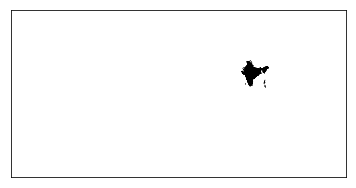

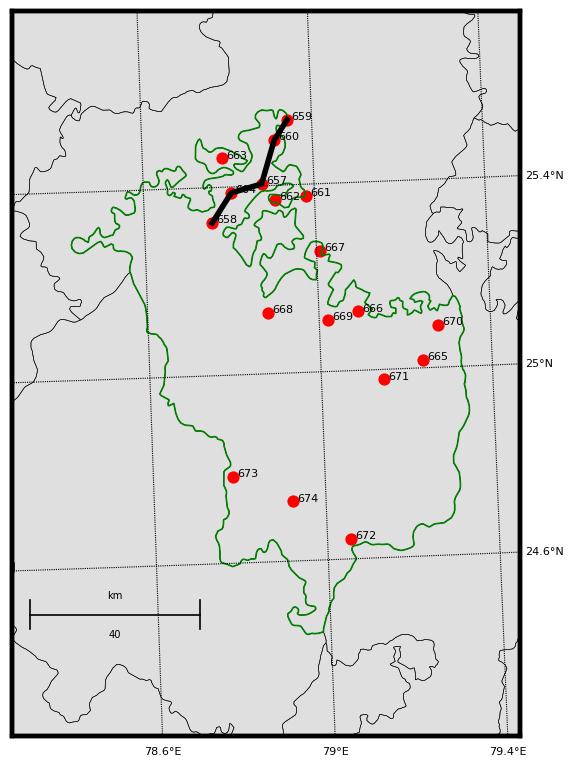

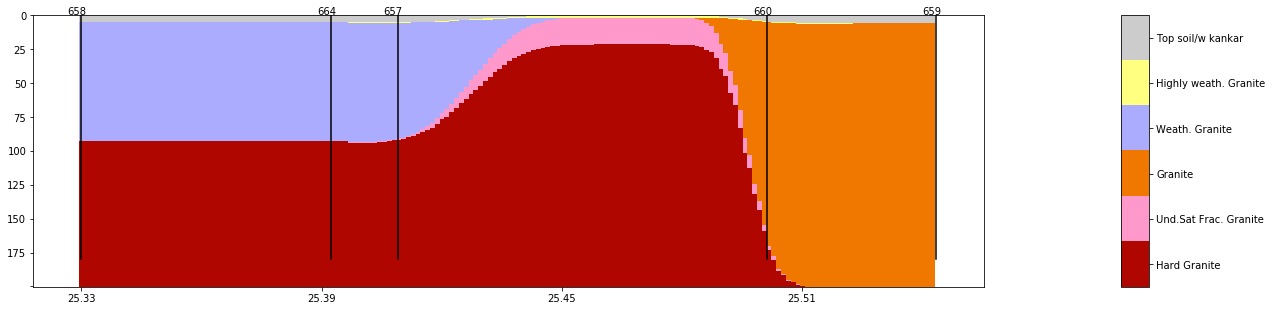

Tikamgarh


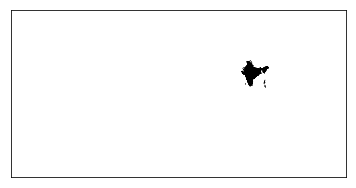

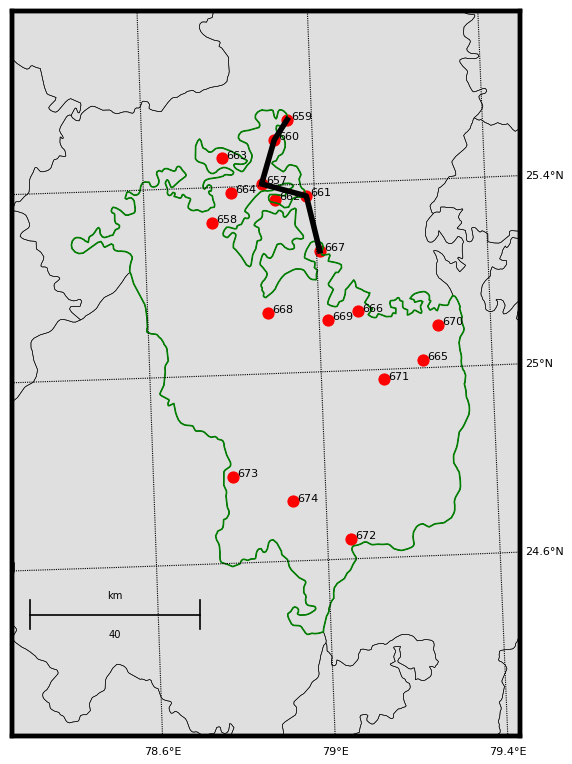

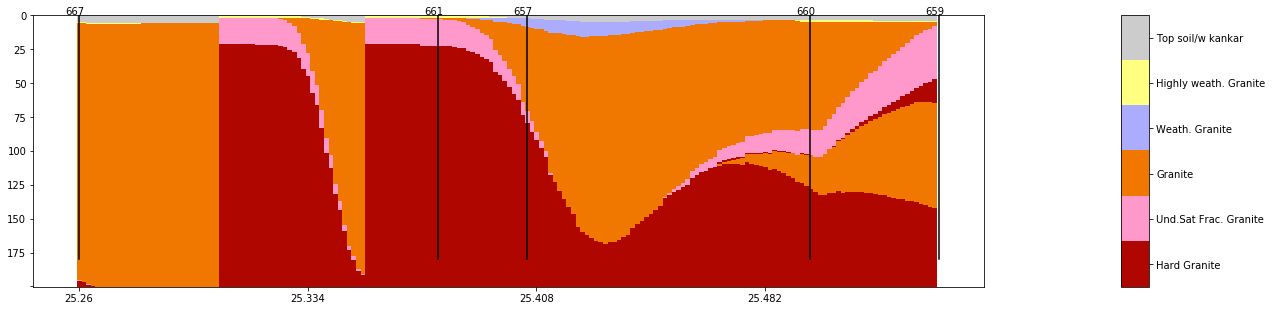

Tikamgarh


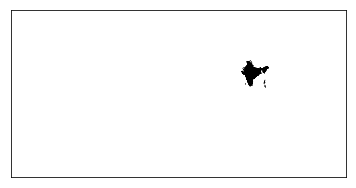

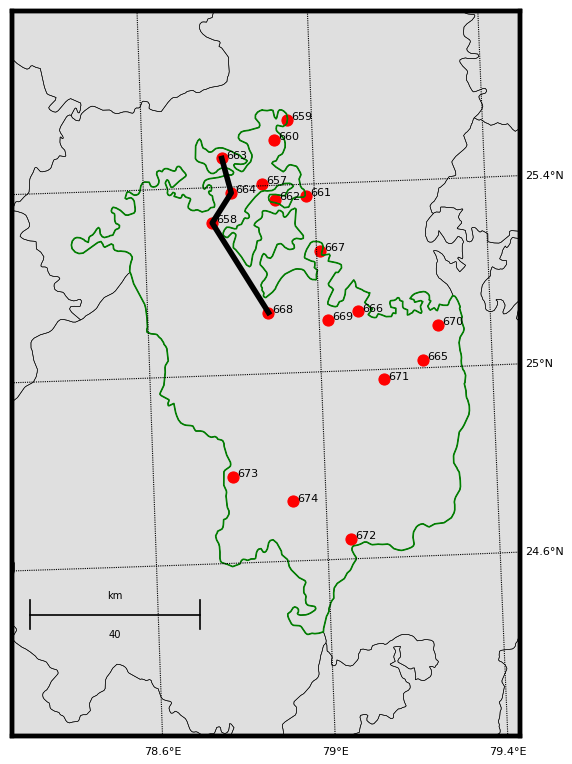

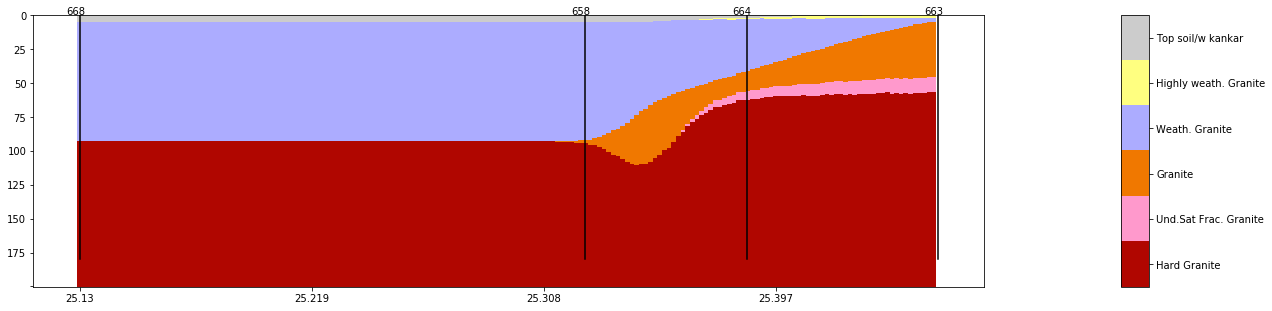

Tikamgarh


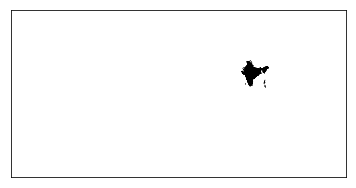

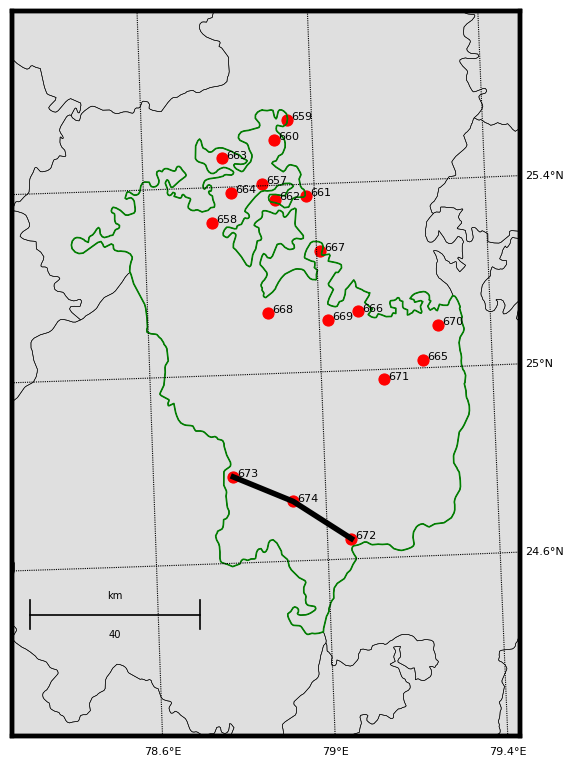

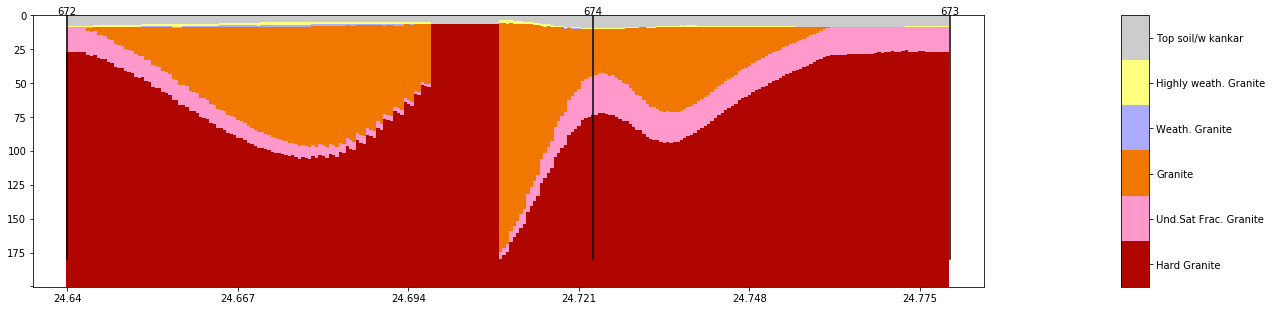

Tikamgarh


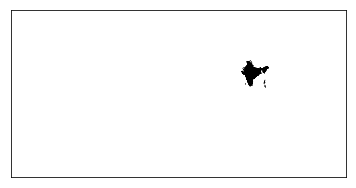

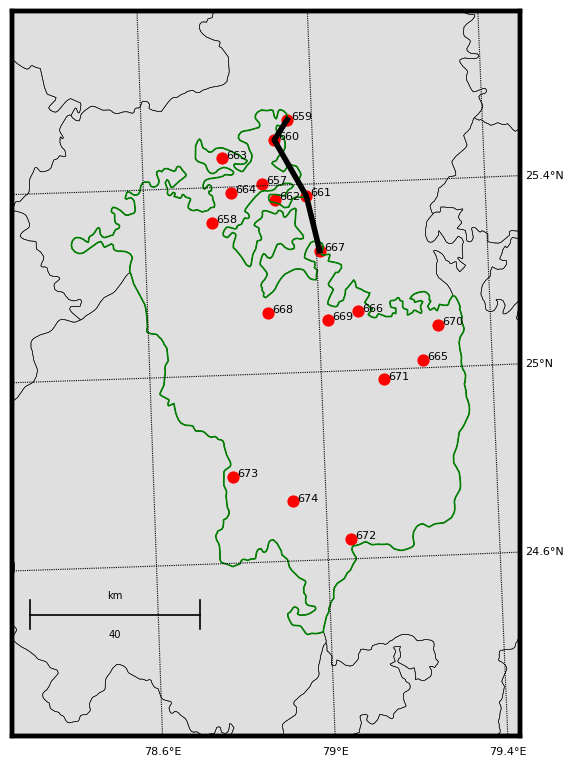

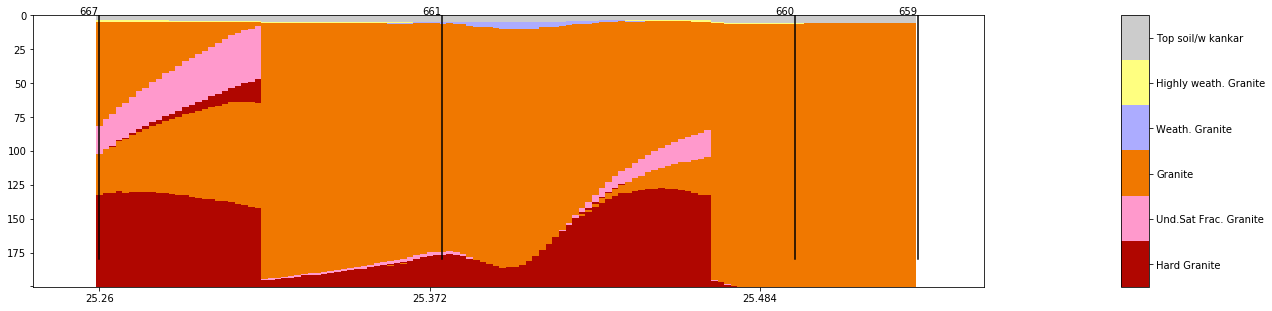

Tikamgarh


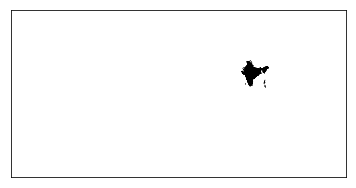

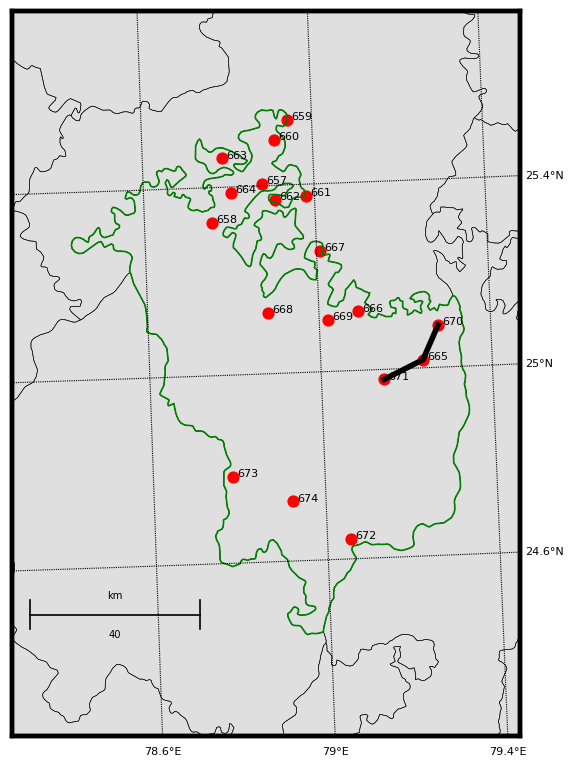

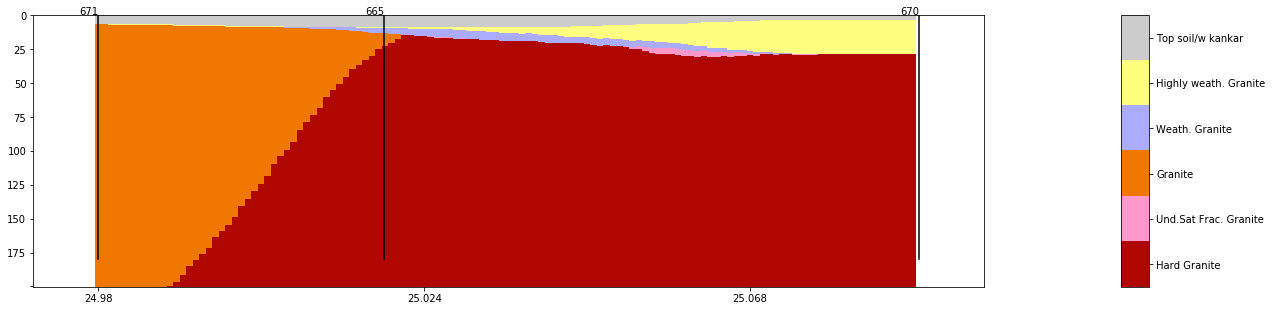

In [196]:
# E,N=vesdf.Easting.values.astype(np.float),vesdf.Northing.values.astype(np.float)
allLoc_numbers=vesdf['VES No.'].values.astype(np.int)
sections=[
    [658,664,657,660,659],[659,660,657,661,667],[663,664,658,668],
    [672,674,673],[667,661,660,659],[671,665,670]
]
sec_image_names=['SW-NE-Twoards North','SW-E-North crecent','N_S western flank','Southern three','S to N Near North','Estern Three']
for section,sec_name in zip(sections,sec_image_names):
    crooked_line=design_crooked_section(section,vesdf)
    crooked_line=np.array(crooked_line).ravel().reshape(len(section),2)

    basemap_plot(vesdf,crooked_line,sec_name)
    xycoords=[]
    sec_logs=[]
    IND=get_indx_of_croockedline(coords,crooked_line)
    for I in IND:
        xycoords.append(coords[I])
        sec_logs.append(np.array(volumelogs[I]['Lithology'] ))
    zl= volumelogs[IND[0]]['Depth']
    # xycoords,zl,sec_logs
    sec_logs=np.array(sec_logs)
    loc1x,loc1y=get_loc_lines(crooked_line,sec_logs)
    yl=np.array(xycoords)[:,1]
    cross_section_plot(sec_logs,np.array(xycoords)[:,1],section,sec_name)

In [68]:
crooked_line

array([[ 78.7584 ,  25.325  ],
       [ 78.80554,  25.38742],
       [ 78.87732,  25.40406],
       [ 78.91078,  25.4964 ],
       [ 78.9429 ,  25.53865]])

In [72]:

# for s,f in zip(sections,sec_image_names):
#     facies_log_plot_multi(ldf, facies_colors,facies_labels,s,f+'.png')
    
# xl,yl,zl,sec_logs=getasection(volumelogs,coords,x=78.8)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [76]:
len(coords)
origcoords=coords.copy()

In [74]:

#     print(distance,index)


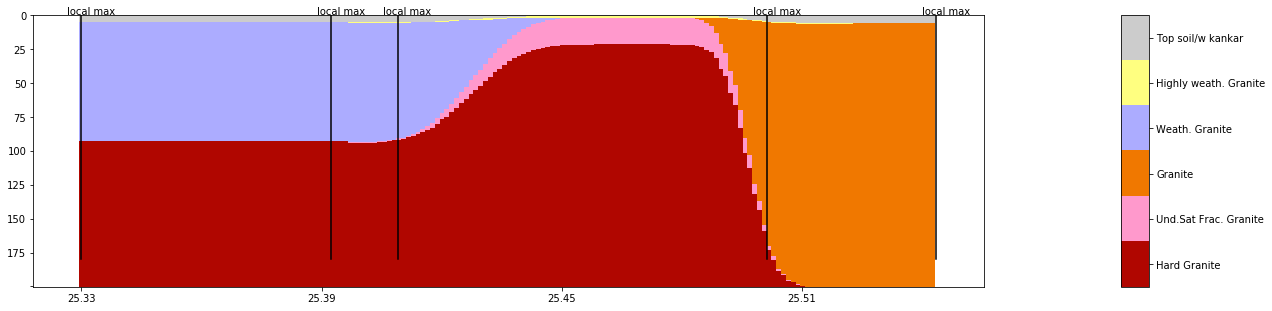

In [175]:
sec_logs.T

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 5, 5, ..., 3, 3, 3],
       [5, 5, 5, ..., 3, 3, 3],
       [5, 5, 5, ..., 3, 3, 3]], dtype=int64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def Gen_RandLine(length, dims=2) :
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length) :
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index-1] + step

    return lineData

def update_lines(num, dataLines, lines) :
    for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2,:num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = [Gen_RandLine(25, 3) for index in range(50)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 25, fargs=(data, lines),
                              interval=50, blit=False)

plt.show()